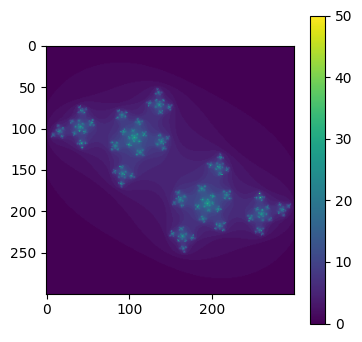

In [1]:
import torch
import matplotlib.pyplot as plt
z0 = torch.complex(torch.arange(-1.5, 1.5, 0.01).view(1, -1), torch.arange(-1.5, 1.5, 0.01).view(-1, 1))

render = torch.zeros(z0.shape)


c = (-0.478,-0.75) 
c = c[0] + c[1]*1j

z = z0
for t in range(50):
    z = z**2 + c
    render += (z.abs() < 2)

# Set aspect ratio to equal to ensure proper display of the fractal
plt.figure(figsize=(4,4))

plt.imshow(render)
plt.colorbar()


torch.Size([6833, 2])


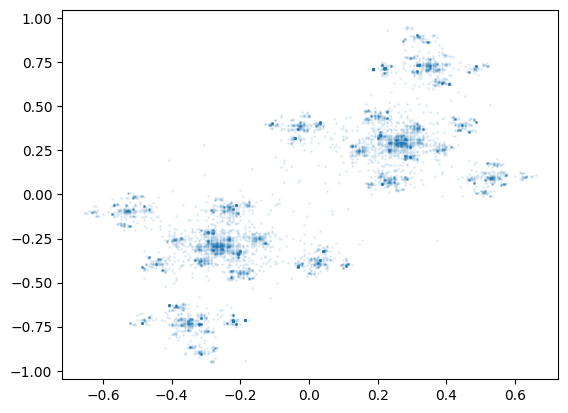

In [2]:
data_to_cat = []

granularity = float(abs(z0[0,0] - z0[0,1]).float())

for y in range(z0.shape[0]):
    for x in range(z0.shape[1]):
        freq = ((render[y, x]/50)**4)*50*2
        number = int(freq) + int(torch.bernoulli(freq - int(freq)))
        points = torch.tensor([y,x],dtype=torch.float32).unsqueeze(0).repeat(number, 1)
        points += torch.randn(points.shape)*granularity
        data_to_cat.append(points)



data = torch.cat(data_to_cat,0)*2 / z0.shape[0] - 1
print(data.shape)
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.1)


In [3]:

# train a vae
from torch import nn
from torch.utils.data import DataLoader

def nonlinearity():
    return torch.nn.LeakyReLU()

class Encoder(nn.Module):
    def __init__(self, n_features=256) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2,n_features),
            nonlinearity(),
            nn.LayerNorm(n_features),
            nn.Linear(n_features,n_features),
            nonlinearity(),
            nn.LayerNorm(n_features),
            nn.Linear(n_features,n_features),
            nonlinearity(),
            nn.LayerNorm(n_features),
            nn.Linear(n_features,n_features),
            nn.Linear(n_features,4),
        )
    def forward(self, x):
        output = self.network(x)
        mu = output[:, :2]
        log_var = output[:, 2:]
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, n_features=256) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, n_features),
            nonlinearity(),
            nn.LayerNorm(n_features),
            nn.Linear(n_features, n_features),
            nonlinearity(),
            nn.LayerNorm(n_features),
            nn.Linear(n_features, n_features),
            nonlinearity(),
            nn.LayerNorm(n_features),
            nn.Linear(n_features, n_features),
            nn.Linear(n_features, 2)
        )
    
    def forward(self, z):
        return self.network(z)

class VAE(nn.Module):
    def __init__(self, n_features=256) -> None:
        super().__init__()
        self.encoder = Encoder(n_features)
        self.decoder = Decoder(n_features)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        
        # Calculate reconstruction loss (MSE)
        reconstruction_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss is the sum of reconstruction loss and KL divergence
        total_loss = reconstruction_loss + kl_loss*0.002
        
        return x_reconstructed, mu, log_var, z, total_loss
    
    def reconstruct_no_noise(self, x):
        mu, log_var = self.encoder(x)
        z = mu
        x_reconstructed = self.decoder(z)
        return x_reconstructed


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# Initialize the VAE model
vae = VAE(384).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

data = data.to(device)



In [11]:
# Create a custom dataset wrapper for the tensor
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, tensor):
        self.tensor = tensor
    
    def __len__(self):
        return len(self.tensor)
    
    def __getitem__(self, idx):
        return self.tensor[idx]

# Create proper dataset and dataloader
dataset = TensorDataset(data)
dl = DataLoader(dataset, batch_size=256, shuffle=True)

# Training loop
num_epochs = 100
losses = []

# Learning rate scheduler
initial_lr = 2e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=initial_lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in dl:
        batch = batch.to(device)
        # Forward pass
        x_reconstructed, mu, log_var, z, loss = vae(batch)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Decay learning rate
    lr_scheduler.step()
    current_lr = lr_scheduler.get_last_lr()[0]
    
    # Track progress
    avg_loss = epoch_loss / len(dl)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}')

Epoch [10/100], Loss: 3.0840, LR: 0.001475
Epoch [20/100], Loss: 2.9075, LR: 0.001088
Epoch [30/100], Loss: 2.9515, LR: 0.000802
Epoch [40/100], Loss: 2.7231, LR: 0.000591
Epoch [50/100], Loss: 2.6862, LR: 0.000436
Epoch [60/100], Loss: 2.6338, LR: 0.000322
Epoch [70/100], Loss: 2.6262, LR: 0.000237
Epoch [80/100], Loss: 2.6180, LR: 0.000175
Epoch [90/100], Loss: 2.5695, LR: 0.000129
Epoch [100/100], Loss: 2.5679, LR: 0.000095


torch.Size([10000, 2])


C:\Users\User\AppData\Local\Temp\ipykernel_20512\2405375681.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


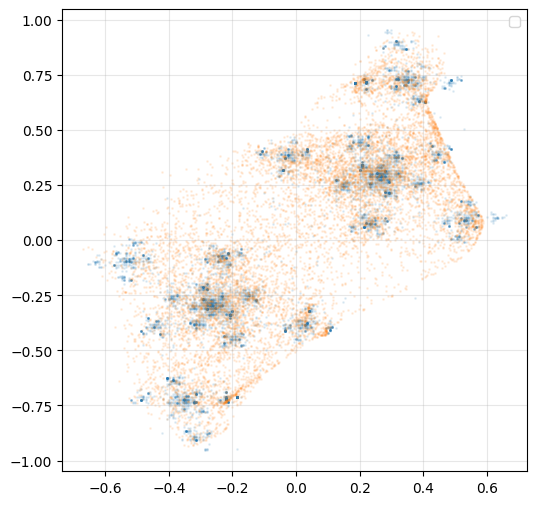

In [12]:

vae.eval()
# Generate samples from the trained model
with torch.no_grad():
    # Sample from the latent space
    z = torch.randn(10000, 2).to(device)
    # Decode the samples
    sampled = vae.decoder(z).cpu()

# Print the shape of the sampled data
print(sampled.shape)

# Create a scatter plot of the sampled data

def scatter(data_list_or_dict: list|dict[str, torch.Tensor]|torch.Tensor, ax: plt.Axes|None = None,s=1):
    if ax is None:
        plt.figure(figsize=(6, 6))
        ax = plt.gca()  
    if isinstance(data_list_or_dict, torch.Tensor):
        ax.scatter(data_list_or_dict[:, 0].detach().cpu(), data_list_or_dict[:, 1].detach().cpu(), alpha=0.1, s=s)
    elif isinstance(data_list_or_dict, list):
        for data in data_list_or_dict:
            ax.scatter(data[:, 0].detach().cpu(), data[:, 1].detach().cpu(), alpha=0.1, s=s)
    elif isinstance(data_list_or_dict, dict):
        for key, data in data_list_or_dict.items():
            ax.scatter(data[:, 0].detach().cpu(), data[:, 1].detach().cpu(), alpha=0.1, s=s, label=key)
    ax.legend()
    ax.grid(True, alpha=0.3)

scatter([data, sampled])

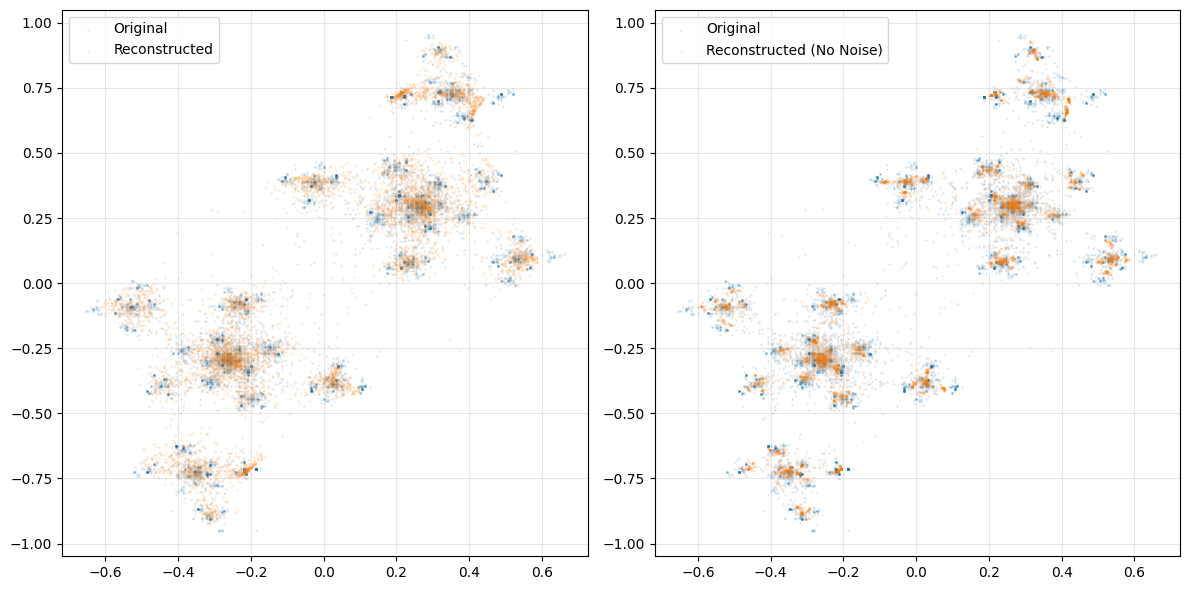

In [13]:
vae.eval()
# plot the latent space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot - regular reconstruction
with torch.no_grad():
    x_reconstructed, mu, log_var, z, total_loss = vae(data)

scatter({'Original': data, 'Reconstructed': x_reconstructed}, ax=ax1)

# Second subplot - reconstruction without noise (using mu directly)
with torch.no_grad():
    x_reconstructed_no_noise = vae.decoder(mu)

scatter({'Original': data, 'Reconstructed (No Noise)': x_reconstructed_no_noise}, ax=ax2)

plt.tight_layout()


C:\Users\User\AppData\Local\Temp\ipykernel_20512\2405375681.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


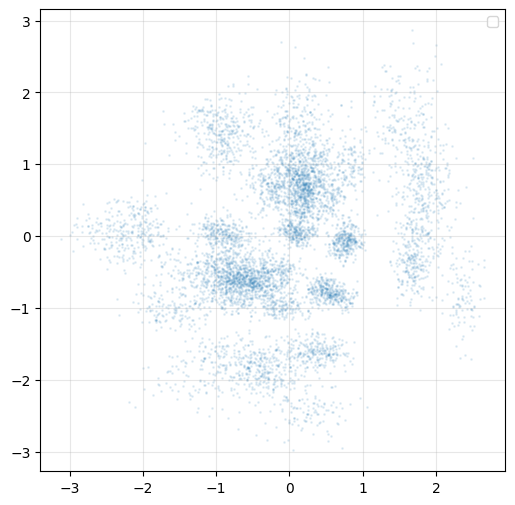

In [14]:
scatter(z)

In [54]:
class Denoiser(nn.Module):
    def __init__(self, blocks=5, in_features=2, features=256):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_features + 1, features))
        layers.append(nn.LeakyReLU())
        for i in range(blocks):
            layers.append(nn.Linear(features, features))
            layers.append(nn.LeakyReLU())
            # layers.append(nn.LayerNorm(features))
        layers.append(nn.Linear(features, features))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Linear(features, 2))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = torch.cat([x, t.unsqueeze(1)], dim=1)
        return self.network(x)

class Scheduler(nn.Module):
    def __init__(self, steps, vae: VAE):
        super().__init__()
        self.n_steps = steps
        self.vae = vae
        self.beta = torch.cat([torch.zeros(1), torch.linspace(0.0001, 0.02, steps)])
        self.sqrt_beta = torch.sqrt(self.beta)
        self.sqrt_one_minus_beta = torch.sqrt(1 - self.beta)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.one_minus_alpha_bar = 1 - self.alpha_bar

    def to(self, device):
        self.beta = self.beta.to(device)
        self.sqrt_beta = self.sqrt_beta.to(device)
        self.sqrt_one_minus_beta = self.sqrt_one_minus_beta.to(device)
        self.alpha = self.alpha.to(device)
        self.alpha_bar = self.alpha_bar.to(device)
        self.sqrt_alpha_bar = self.sqrt_alpha_bar.to(device)
        self.one_minus_alpha_bar = self.one_minus_alpha_bar.to(device)
        return self
        
    def sample_xt(self, x0, t):
        if isinstance(t, int):
            t = torch.tensor([t], device=x0.device)
        z_mu, z_log_var = self.vae.encoder(x0)
        # add noise to z
        z = z_mu * self.sqrt_alpha_bar[t].unsqueeze(1) + torch.randn_like(z_mu) * self.one_minus_alpha_bar[t].unsqueeze(1)**0.5
        xt = self.vae.decoder(z)
        return xt, z
    
    def forward(self, xt, t, steps=1):
        zt, zt_log_var = self.vae.encoder(xt)
        for t in range(t+1, t+steps+1):
            if isinstance(t, int):
                t = torch.tensor([t], device=xt.device)
            zt = zt * self.sqrt_one_minus_beta[t].unsqueeze(1) + torch.randn_like(zt) * self.beta[t].unsqueeze(1)**0.5
        xt = self.vae.decoder(zt)
        return xt, zt
    
    def sample_xtm1_and_xt(self, x0, t, use_z_var=False):
        if isinstance(t, int):
            t = torch.tensor([t], device=x0.device)
        z0_mu, ztm1_log_var = self.vae.encoder(x0)
        if use_z_var:
            std = torch.exp(0.5 * ztm1_log_var)
            z0 = z0_mu + torch.randn_like(z0_mu) * std
        else:
            z0 = z0_mu

        # add noise to z
        ztm1 = z0 * self.sqrt_alpha_bar[t-1].unsqueeze(1) + torch.randn_like(z0) * self.one_minus_alpha_bar[t-1].unsqueeze(1)**0.5
        xtm1 = self.vae.decoder(ztm1)
        zt = ztm1 * self.sqrt_one_minus_beta[t].unsqueeze(1) + torch.randn_like(ztm1) * self.beta[t].unsqueeze(1)**0.5
        xt = self.vae.decoder(zt)
        return xtm1, xt
    
denoiser = Denoiser(blocks=3, features=1024).to(device)
# denoizer predicts x0 from xt
    
scheduler = Scheduler(steps=64, vae=vae).to(device)


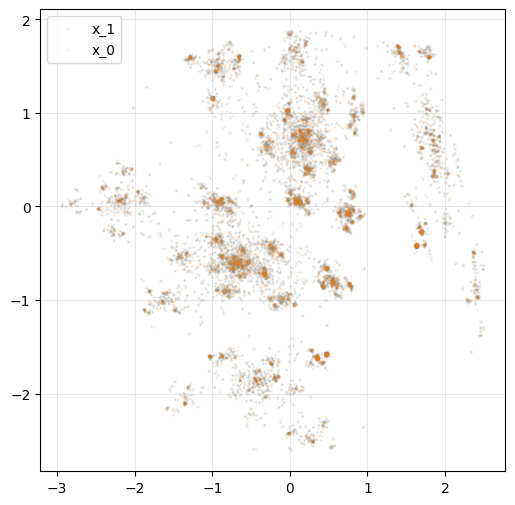

In [55]:
x0 = data
t = 1
xt1, zt1 = scheduler.sample_xt(x0, t)
xt2, zt2 = scheduler.forward(x0, 0, steps=t)
scatter({f'x_{t}': zt1,f'x_{t-1}': zt2})

In [56]:
crit = nn.MSELoss()
optim = torch.optim.Adam(denoiser.parameters(), lr=1e-5)
pred_residual = False

In [57]:
# train denoiser

epochs = 1000
vae.eval()
denoiser.train()
for epoch in range(epochs):
    epoch_loss = 0
    for x0 in dl:
        x0 = x0.to(device)
        t = torch.randint(1, scheduler.n_steps+1, (x0.shape[0],), device=x0.device)
        with torch.no_grad():
            xtm1, xt = scheduler.sample_xtm1_and_xt(x0, t, use_z_var=True)
        optim.zero_grad()
        pred = denoiser(xt, t / scheduler.n_steps)
        if pred_residual:
            pred = xt - pred
        loss = crit(pred, xtm1)
        loss.backward()
        optim.step()
        epoch_loss += loss.item()**0.5
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dl):.4f}')


Epoch 20/1000, Loss: 0.0446
Epoch 40/1000, Loss: 0.0447
Epoch 60/1000, Loss: 0.0457
Epoch 80/1000, Loss: 0.0457
Epoch 100/1000, Loss: 0.0458
Epoch 120/1000, Loss: 0.0458
Epoch 140/1000, Loss: 0.0465
Epoch 160/1000, Loss: 0.0489
Epoch 180/1000, Loss: 0.0473
Epoch 200/1000, Loss: 0.0475
Epoch 220/1000, Loss: 0.0460
Epoch 240/1000, Loss: 0.0458
Epoch 260/1000, Loss: 0.0466
Epoch 280/1000, Loss: 0.0451


KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_15236\2405375681.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


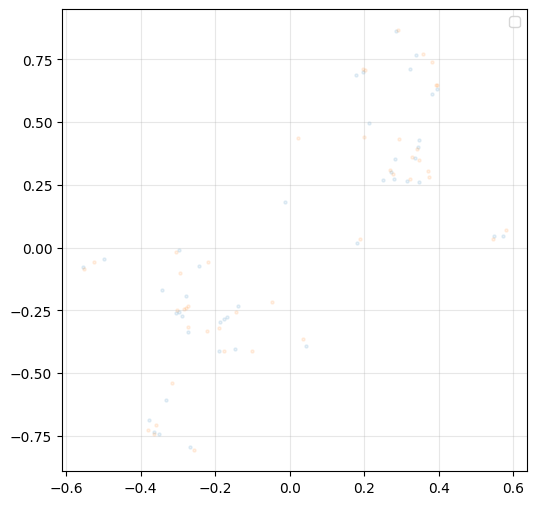

In [575]:
scatter([pred, xtm1],s=5)

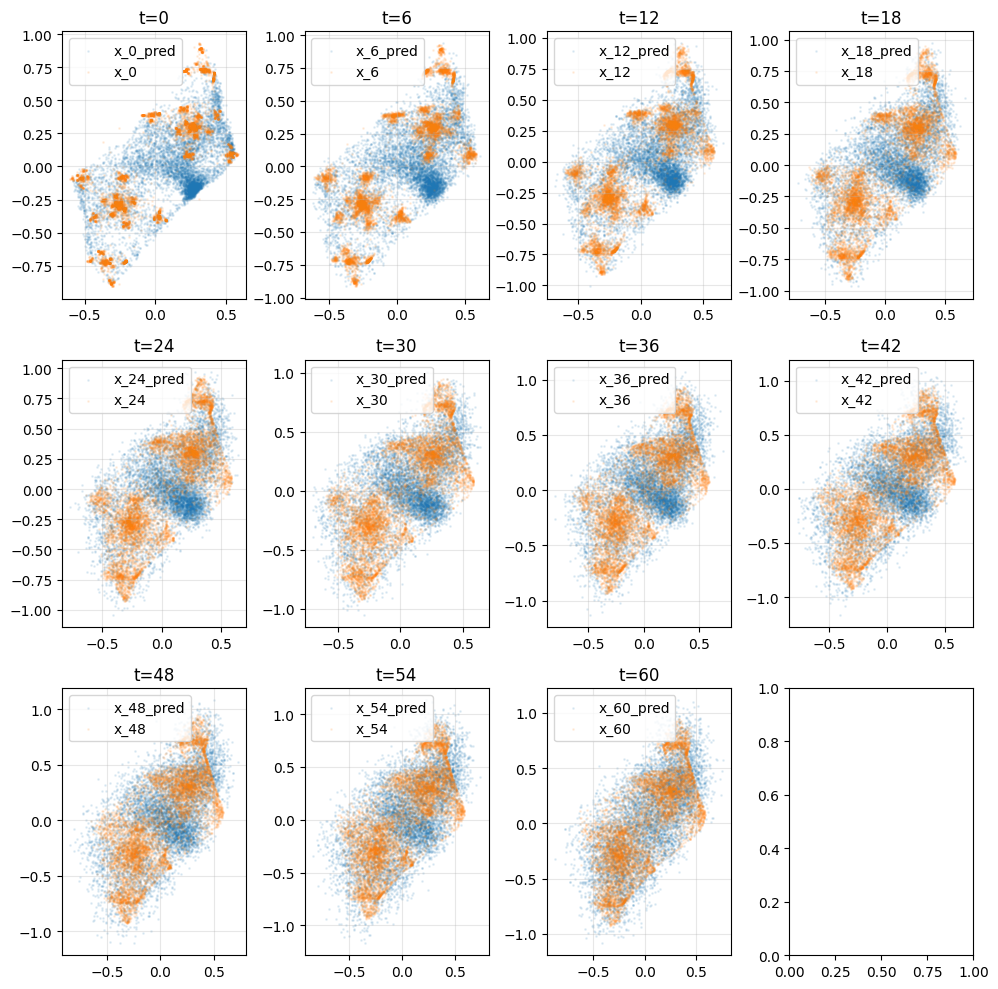

In [63]:
from math import ceil

denoiser.eval()
def sample_xtm1(denoiser: Denoiser, xt, t, scheduler: Scheduler):
    with torch.no_grad():
        xtm1_mu = denoiser(xt, t.float() / scheduler.n_steps)
        xtm1_var = ((1-scheduler.alpha_bar[t-1])/(1-scheduler.alpha_bar[t])*scheduler.beta[t]).unsqueeze(1)
        xtm1 = xtm1_mu + (torch.randn_like(xtm1_mu) * torch.sqrt(xtm1_var)*0.5) * (t.unsqueeze(1)>0)
        return xtm1


T = scheduler.n_steps
# z_t = torch.randn(10000,2).to(device)
# x_t = scheduler.vae.decoder(z_t)
x_t = scheduler.sample_xt(data, [T])[0]
q_x_0 = scheduler.sample_xt(data, [0])[0]
x_t_list = [x_t]
for t in range(T , 0, -1):
    t_batch = torch.ones(x_t.shape[0], dtype=torch.long, device=x_t.device) * t
    pred = sample_xtm1(denoiser, x_t, t_batch, scheduler)
    if pred_residual:
        x_tm1 = x_t - pred
    else:
        x_tm1 = pred
    x_t_list.append(x_tm1)
    x_t = x_tm1

x_t_list = list(reversed(x_t_list))

i = 0
fig, axs = plt.subplots(ceil((10+1)/4),4,  figsize=(10, 10))
# for t, x_t in enumerate(x_t_list[::len(x_t_list)//10]):
for t in range(0, T+1, T//10):
    x_t = x_t_list[t]
    ax = axs[i//4, i%4]
    scatter({f'x_{t}_pred': x_t, f'x_{t}': scheduler.sample_xt(data, [t])[0]}, ax=ax)
    ax.set_title(f't={t}')
    i += 1
plt.tight_layout()
plt.show()



In [80]:
t_batch

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

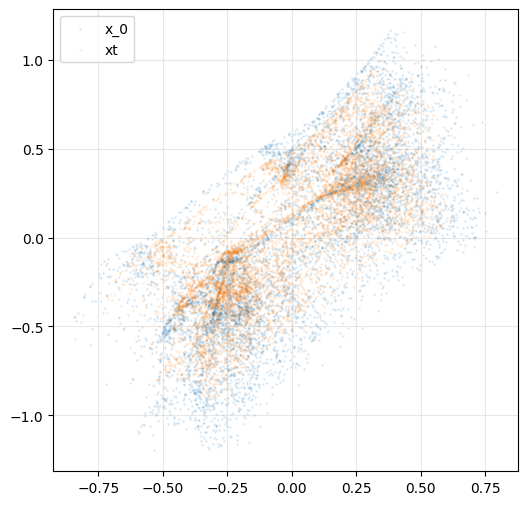

In [77]:
t = 0
scatter({f'x_{t}': x_t_list[t], 'xt': x_t_list[64]})

In [345]:
next(vae.encoder.parameters()).device

device(type='cuda', index=0)

In [3]:
import time
i +=1
time.sleep(1)
i

2